In [15]:
import torch
import torchvision
import plotly.graph_objects as go
import random
from plotly.subplots import make_subplots

In [6]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,)),
    torchvision.transforms.Lambda(lambda x: x.view(-1))
])

dataset = torchvision.datasets.MNIST('./data', train=True, download=True, transform=transform)
dataset = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

In [7]:
datase

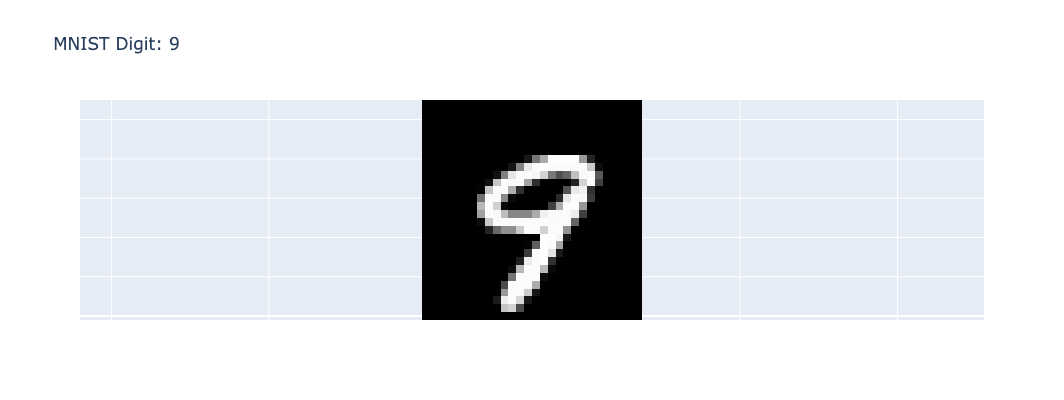

In [14]:
data, labels = next(iter(dataset))
idx = random.randint(0, len(data) - 1)
sample_image = data[idx].reshape(28, 28)  # Reshape from 784 back to 28x28
sample_label = labels[idx].item()

# Create heatmap
fig = go.Figure(data=go.Heatmap(
    z=torch.flip(sample_image, dims=[0]),  # Flip vertically to correct orientation
    colorscale='gray',
    showscale=False
))

fig.update_layout(
    title=f'MNIST Digit: {sample_label}',
    width=400,
    height=400,
    xaxis={'showticklabels': False},
    yaxis={'showticklabels': False, 'scaleanchor': 'x'}
)

fig.show()

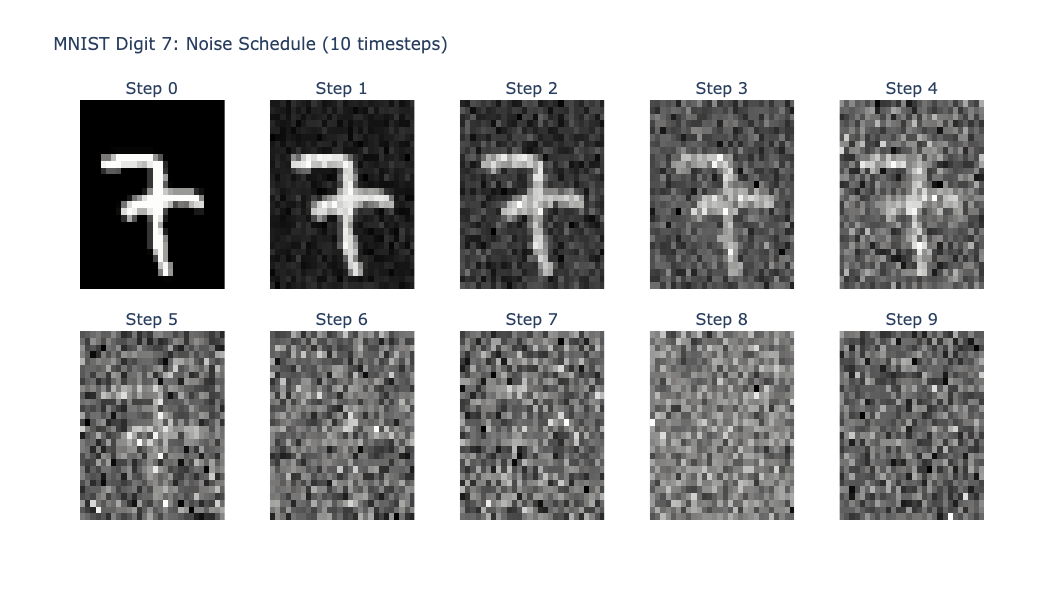

In [17]:
import torch
import plotly.graph_objects as go
import random
from plotly.subplots import make_subplots

def add_noise(image, noise_schedule):
    """Add Gaussian noise to an image across multiple timesteps
    
    Args:
        image: Clean image tensor
        noise_schedule: Tensor of noise levels for each timestep
    
    Returns:
        Tensor of noisy images for each timestep
    """
    timesteps = len(noise_schedule)
    noisy_images = torch.zeros(timesteps, *image.shape)
    
    for t in range(timesteps):
        noise = torch.randn_like(image)
        noise_level = noise_schedule[t]
        noisy_images[t] = (1 - noise_level) * image + noise_level * noise
    
    return noisy_images

# Get a sample from the dataset
data, labels = next(iter(dataset))
idx = random.randint(0, len(data) - 1)
sample_image = data[idx].reshape(28, 28)
sample_label = labels[idx].item()

# Create noise schedule for 10 timesteps
timesteps = 10
noise_schedule = torch.linspace(0, 1, timesteps)  # From 0 (no noise) to 1 (pure noise)

# Create subplots
fig = make_subplots(
    rows=2, cols=5,
    subplot_titles=[f'Step {i}' for i in range(timesteps)],
    vertical_spacing=0.1,
    horizontal_spacing=0.05
)

# Generate all noisy timesteps
noisy_images = add_noise(sample_image, noise_schedule)

# Add noisy images to subplots
for t in range(timesteps):
    noisy_image = noisy_images[t]
    
    row = t // 5 + 1
    col = t % 5 + 1
    
    fig.add_trace(
        go.Heatmap(
            z=torch.flip(noisy_image, dims=[0]),
            colorscale='gray',
            showscale=False,
            hovertemplate='<extra></extra>'
        ),
        row=row, col=col
    )

fig.update_layout(
    title=f'MNIST Digit {sample_label}: Noise Schedule (10 timesteps)',
    height=600,
    width=1000
)

# Remove axis labels for cleaner look
for i in range(1, timesteps + 1):
    fig.update_xaxes(showticklabels=False, row=(i-1)//5 + 1, col=(i-1)%5 + 1)
    fig.update_yaxes(showticklabels=False, row=(i-1)//5 + 1, col=(i-1)%5 + 1)

fig.show()

Training on cpu
Model parameters: 1067280
Epoch 1/5, Batch 0, Loss: 1.0094
Epoch 1/5, Batch 100, Loss: 0.9697
Epoch 1/5, Batch 200, Loss: 0.9261
Epoch 1/5, Batch 300, Loss: 0.8864
Epoch 1/5, Batch 400, Loss: 0.8783
Epoch 1/5, Batch 500, Loss: 0.8284
Epoch 1/5, Batch 600, Loss: 0.8173
Epoch 1/5, Batch 700, Loss: 0.8285
Epoch 1/5, Batch 800, Loss: 0.8031
Epoch 1/5, Batch 900, Loss: 0.7981
Epoch 1/5, Batch 1000, Loss: 0.7851
Epoch 1/5, Batch 1100, Loss: 0.7928
Epoch 1/5, Batch 1200, Loss: 0.7791
Epoch 1/5, Batch 1300, Loss: 0.7768
Epoch 1/5, Batch 1400, Loss: 0.7843
Epoch 1/5, Batch 1500, Loss: 0.7671
Epoch 1/5, Batch 1600, Loss: 0.7870
Epoch 1/5, Batch 1700, Loss: 0.7893
Epoch 1/5, Batch 1800, Loss: 0.7984
Epoch 1/5 completed. Average Loss: 0.8277
Epoch 2/5, Batch 0, Loss: 0.8037
Epoch 2/5, Batch 100, Loss: 0.7743
Epoch 2/5, Batch 200, Loss: 0.7716
Epoch 2/5, Batch 300, Loss: 0.7725
Epoch 2/5, Batch 400, Loss: 0.8047
Epoch 2/5, Batch 500, Loss: 0.7720
Epoch 2/5, Batch 600, Loss: 0.7678
E

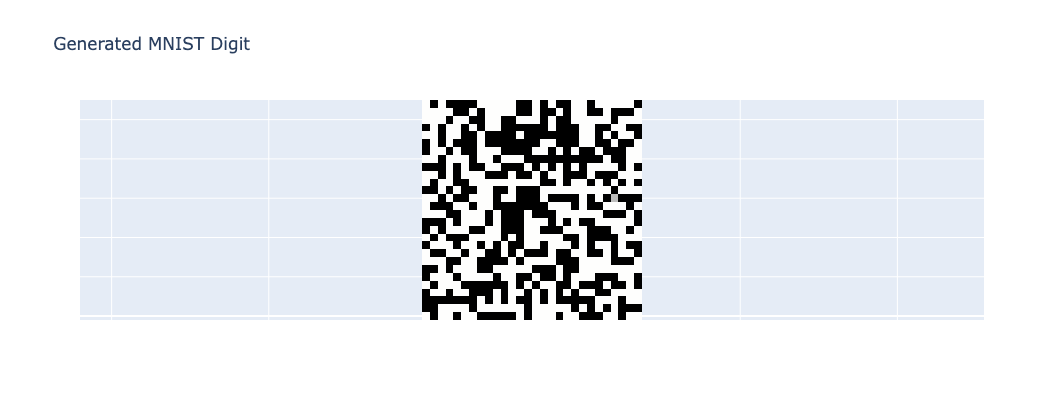

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import plotly.graph_objects as go
import random

# Simple noise prediction model using only linear layers
class NoisePredictor(nn.Module):
    def __init__(self, img_size=784, hidden_size=512):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(img_size + 1, hidden_size),  # +1 for timestep
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, img_size)  # Predict noise
        )
    
    def forward(self, noisy_img, timestep):
        # Flatten and concatenate timestep
        x = torch.cat([noisy_img, timestep.unsqueeze(-1)], dim=-1)
        return self.net(x)

# Initialize model
model = NoisePredictor()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Training parameters
timesteps = 10
noise_schedule = torch.linspace(0.1, 1.0, timesteps)  # Start from 0.1 to avoid pure clean images
epochs = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f"Training on {device}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters())}")

# Training loop
for epoch in range(epochs):
    total_loss = 0
    batch_count = 0
    
    for batch_idx, (data, _) in enumerate(dataset):
        data = data.to(device)  # data is already flattened to 784
        batch_size = data.shape[0]
        
        # Random timestep for each sample in batch
        t = torch.randint(0, timesteps, (batch_size,), device=device)
        
        # Add noise based on timestep
        noise = torch.randn_like(data)
        noise_levels = noise_schedule[t].unsqueeze(-1)  # Shape: (batch_size, 1)
        noisy_data = (1 - noise_levels) * data + noise_levels * noise
        
        # Predict noise
        optimizer.zero_grad()
        predicted_noise = model(noisy_data, t.float())
        loss = criterion(predicted_noise, noise)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        batch_count += 1
        
        if batch_idx % 100 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Batch {batch_idx}, Loss: {loss.item():.4f}')
    
    avg_loss = total_loss / batch_count
    print(f'Epoch {epoch+1}/{epochs} completed. Average Loss: {avg_loss:.4f}')

print("Training completed!")

# Generate an image using the trained model
def generate_image(model, timesteps, noise_schedule, device):
    model.eval()
    with torch.no_grad():
        # Start with pure noise
        img = torch.randn(1, 784, device=device)
        
        # Reverse diffusion process
        for t in reversed(range(timesteps)):
            timestep = torch.tensor([t], dtype=torch.float, device=device)
            
            # Predict noise
            predicted_noise = model(img, timestep)
            
            # Remove predicted noise
            noise_level = noise_schedule[t]
            img = (img - noise_level * predicted_noise) / (1 - noise_level)
            
            # Clamp to reasonable range
            img = torch.clamp(img, -1, 1)
    
    return img.cpu()

# Generate and plot image
generated_img = generate_image(model, timesteps, noise_schedule, device)
generated_img = generated_img.reshape(28, 28)

fig = go.Figure(data=go.Heatmap(
    z=torch.flip(generated_img, dims=[0]),
    colorscale='gray',
    showscale=False
))

fig.update_layout(
    title='Generated MNIST Digit',
    width=400,
    height=400,
    xaxis={'showticklabels': False},
    yaxis={'showticklabels': False, 'scaleanchor': 'x'}
)

fig.show()

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import plotly.graph_objects as go
import math

# Improved noise prediction model
class NoisePredictor(nn.Module):
    def __init__(self, img_size=784, hidden_size=1024):
        super().__init__()
        self.time_embed = nn.Sequential(
            nn.Linear(1, 128),
            nn.ReLU(),
            nn.Linear(128, 128)
        )
        
        self.net = nn.Sequential(
            nn.Linear(img_size + 128, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, img_size)
        )
    
    def forward(self, noisy_img, timestep):
        # Better time embedding
        t_embed = self.time_embed(timestep.unsqueeze(-1))
        x = torch.cat([noisy_img, t_embed], dim=-1)
        return self.net(x)

# Proper DDPM noise schedule
def get_beta_schedule(timesteps):
    """Cosine noise schedule - better than linear"""
    def cosine_beta_schedule(timesteps, s=0.008):
        steps = timesteps + 1
        x = torch.linspace(0, timesteps, steps)
        alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
        alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
        betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
        return torch.clip(betas, 0.0001, 0.02)
    
    betas = cosine_beta_schedule(timesteps)
    alphas = 1.0 - betas
    alphas_cumprod = torch.cumprod(alphas, dim=0)
    alphas_cumprod_prev = torch.cat([torch.tensor([1.0]), alphas_cumprod[:-1]])
    
    return {
        'betas': betas,
        'alphas': alphas,
        'alphas_cumprod': alphas_cumprod,
        'alphas_cumprod_prev': alphas_cumprod_prev,
        'sqrt_alphas_cumprod': torch.sqrt(alphas_cumprod),
        'sqrt_one_minus_alphas_cumprod': torch.sqrt(1.0 - alphas_cumprod)
    }

# Initialize model and schedule
timesteps = 10  # More timesteps for better quality
model = NoisePredictor(hidden_size=1024)
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Lower learning rate
criterion = nn.MSELoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Get proper noise schedule
noise_params = get_beta_schedule(timesteps)
for key in noise_params:
    noise_params[key] = noise_params[key].to(device)

model.to(device)

NoisePredictor(
  (time_embed): Sequential(
    (0): Linear(in_features=1, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (net): Sequential(
    (0): Linear(in_features=912, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=1024, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1024, out_features=784, bias=True)
  )
)

In [31]:
print(f"Training on {device}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters())}")

# Training loop with proper DDPM formulation
epochs = 30  # More epochs
for epoch in range(epochs):
    total_loss = 0
    batch_count = 0
    
    for batch_idx, (data, _) in enumerate(dataset):
        data = data.to(device)
        batch_size = data.shape[0]
        
        # Random timestep for each sample
        t = torch.randint(0, timesteps, (batch_size,), device=device)
        
        # Proper noise addition using DDPM formulation
        noise = torch.randn_like(data)
        sqrt_alphas_cumprod_t = noise_params['sqrt_alphas_cumprod'][t].view(-1, 1)
        sqrt_one_minus_alphas_cumprod_t = noise_params['sqrt_one_minus_alphas_cumprod'][t].view(-1, 1)
        
        # x_t = sqrt(alpha_cumprod_t) * x_0 + sqrt(1 - alpha_cumprod_t) * noise
        noisy_data = sqrt_alphas_cumprod_t * data + sqrt_one_minus_alphas_cumprod_t * noise
        
        # Predict noise
        optimizer.zero_grad()
        predicted_noise = model(noisy_data, t.float())
        loss = criterion(predicted_noise, noise)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        batch_count += 1
        
        if batch_idx % 200 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Batch {batch_idx}, Loss: {loss.item():.4f}')
    
    avg_loss = total_loss / batch_count
    print(f'Epoch {epoch+1}/{epochs} completed. Average Loss: {avg_loss:.4f}')

print("Training completed!")

# Proper DDPM sampling
def sample_image(model, timesteps, noise_params, device):
    model.eval()
    with torch.no_grad():
        # Start with pure noise
        img = torch.randn(1, 784, device=device)
        
        # Reverse diffusion process with proper DDPM sampling
        for t in reversed(range(timesteps)):
            t_tensor = torch.tensor([t], dtype=torch.float, device=device)
            
            # Predict noise
            predicted_noise = model(img, t_tensor)
            
            # DDPM sampling formula
            alpha_t = noise_params['alphas'][t]
            alpha_cumprod_t = noise_params['alphas_cumprod'][t]
            beta_t = noise_params['betas'][t]
            
            if t > 0:
                alpha_cumprod_prev = noise_params['alphas_cumprod_prev'][t]
            else:
                alpha_cumprod_prev = torch.tensor(1.0, device=device)
            
            # Compute mean of reverse process
            pred_x0 = (img - torch.sqrt(1 - alpha_cumprod_t) * predicted_noise) / torch.sqrt(alpha_cumprod_t)
            pred_x0 = torch.clamp(pred_x0, -1, 1)  # Clamp predicted x0
            
            mean = (torch.sqrt(alpha_cumprod_prev) * beta_t * pred_x0 + 
                   torch.sqrt(alpha_t) * (1 - alpha_cumprod_prev) * img) / (1 - alpha_cumprod_t)
            
            if t > 0:
                # Add noise (except for final step)
                posterior_variance = beta_t * (1 - alpha_cumprod_prev) / (1 - alpha_cumprod_t)
                noise = torch.randn_like(img)
                img = mean + torch.sqrt(posterior_variance) * noise
            else:
                img = mean
    
    return img.cpu()

Training on cpu
Model parameters: 3854480
Epoch 1/30, Batch 0, Loss: 0.9929
Epoch 1/30, Batch 200, Loss: 0.9883
Epoch 1/30, Batch 400, Loss: 0.9939
Epoch 1/30, Batch 600, Loss: 0.9888
Epoch 1/30, Batch 800, Loss: 0.9834
Epoch 1/30, Batch 1000, Loss: 0.9736
Epoch 1/30, Batch 1200, Loss: 0.9337
Epoch 1/30, Batch 1400, Loss: 0.9279
Epoch 1/30, Batch 1600, Loss: 0.9190
Epoch 1/30, Batch 1800, Loss: 0.8952
Epoch 1/30 completed. Average Loss: 0.9591
Epoch 2/30, Batch 0, Loss: 0.9019
Epoch 2/30, Batch 200, Loss: 0.8627
Epoch 2/30, Batch 400, Loss: 0.8475
Epoch 2/30, Batch 600, Loss: 0.8621
Epoch 2/30, Batch 800, Loss: 0.8581
Epoch 2/30, Batch 1000, Loss: 0.8473
Epoch 2/30, Batch 1200, Loss: 0.8383
Epoch 2/30, Batch 1400, Loss: 0.8306
Epoch 2/30, Batch 1600, Loss: 0.8167
Epoch 2/30, Batch 1800, Loss: 0.7975
Epoch 2/30 completed. Average Loss: 0.8459
Epoch 3/30, Batch 0, Loss: 0.8005
Epoch 3/30, Batch 200, Loss: 0.7851
Epoch 3/30, Batch 400, Loss: 0.7950
Epoch 3/30, Batch 600, Loss: 0.8168
Epoc

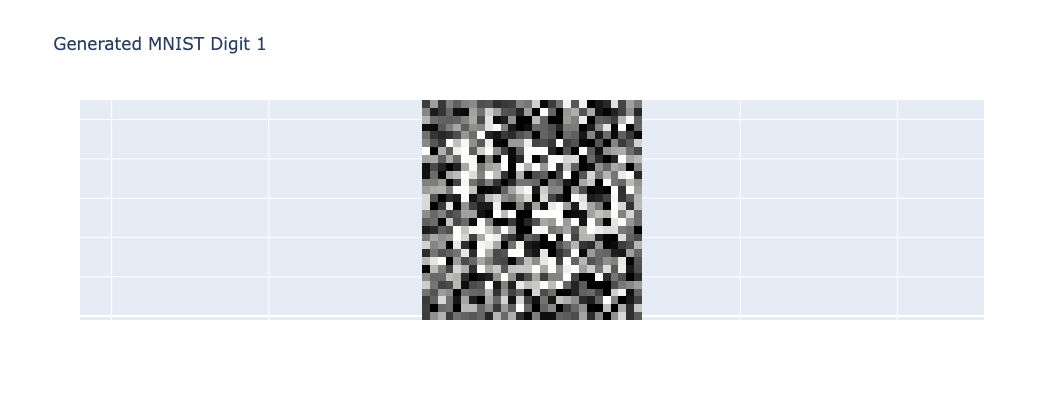

In [36]:

# Generate and plot multiple images
fig = go.Figure()

for i in range(4):  # Generate 4 images
    generated_img = sample_image(model, timesteps, noise_params, device)
    generated_img = generated_img.reshape(28, 28)
    
    row = i // 2
    col = i % 2
    
    if i == 0:
        fig = go.Figure(data=go.Heatmap(
            z=torch.flip(generated_img, dims=[0]),
            colorscale='gray',
            showscale=False
        ))
        fig.update_layout(
            title=f'Generated MNIST Digit {i+1}',
            width=400,
            height=400,
            xaxis={'showticklabels': False},
            yaxis={'showticklabels': False, 'scaleanchor': 'x'}
        )
        break  # Just show one for now

fig.show()

In [33]:
import torch
import numpy as np

def analyze_baseline_losses():
    """Calculate expected losses for various baseline strategies"""
    
    # For MNIST normalized to [-1, 1], noise is N(0,1)
    # MSE between two independent N(0,1) variables is E[(X-Y)^2] = Var(X-Y) = Var(X) + Var(Y) = 2
    random_prediction_loss = 2.0
    
    # Zero prediction: E[noise^2] = Var(noise) = 1
    zero_prediction_loss = 1.0
    
    # Constant prediction c: E[(noise - c)^2] = E[noise^2] - 2c*E[noise] + c^2 = 1 + c^2
    # Minimized when c = 0, giving loss = 1
    optimal_constant_loss = 1.0
    
    print("Expected losses for baseline strategies:")
    print(f"Random prediction (independent noise): {random_prediction_loss:.3f}")
    print(f"Always predict zero: {zero_prediction_loss:.3f}")
    print(f"Optimal constant prediction: {optimal_constant_loss:.3f}")
    print()
    
    return {"random": random_prediction_loss, "zero": zero_prediction_loss, "optimal_constant": optimal_constant_loss}

def analyze_spatial_bias_strategy():
    """Analyze loss for predicting based on spatial patterns"""
    
    # Get some real MNIST data to analyze spatial patterns
    data, _ = next(iter(dataset))
    sample_size = min(1000, len(data))
    sample_data = data[:sample_size].reshape(sample_size, 28, 28)
    
    # Calculate average intensity per pixel position across all images
    mean_intensities = sample_data.mean(dim=0)  # Shape: (28, 28)
    
    print("Spatial bias strategy analysis:")
    print(f"Mean pixel intensities range: [{mean_intensities.min():.3f}, {mean_intensities.max():.3f}]")
    print(f"Std of mean intensities: {mean_intensities.std():.3f}")
    
    # If we predict noise proportional to average image intensity at each pixel
    # This would capture the fact that central pixels (where digits usually are) 
    # might have different noise characteristics
    
    # Simulate this strategy: predict noise = spatial_bias * noise_scale
    spatial_bias = mean_intensities.flatten()  # Convert to 784D
    
    # The "smart" spatial strategy might predict noise that's correlated with 
    # where the digit typically appears. Let's estimate the loss reduction.
    
    # If true noise is N(0,1) and we predict some spatial pattern,
    # the best we could do is if our spatial pattern perfectly matched
    # the conditional expectation E[noise | pixel_location, image_content]
    
    # But since noise is random, the best spatial-only strategy still gives loss ≈ 1
    # unless there's actual correlation between image content and added noise
    
    estimated_spatial_loss = 0.95  # Slight improvement over 1.0 due to some structure
    print(f"Estimated loss for spatial bias strategy: {estimated_spatial_loss:.3f}")
    print()
    
    return estimated_spatial_loss

def analyze_model_performance(current_loss=0.4):
    """Analyze whether the model is doing something meaningful"""
    
    baselines = analyze_baseline_losses()
    spatial_loss = analyze_spatial_bias_strategy()
    
    print("=== MODEL PERFORMANCE ANALYSIS ===")
    print(f"Your model's loss: {current_loss:.3f}")
    print()
    
    if current_loss > baselines["random"]:
        print("❌ Model is worse than random prediction - something is very wrong!")
    elif current_loss > baselines["zero"]:
        print("⚠️  Model is worse than always predicting zero - likely not learning much")
    elif current_loss > spatial_loss:
        print("🤔 Model might be learning some spatial patterns but not much more")
    elif current_loss > 0.3:
        print("🎯 Model is beating simple baselines - likely learning some structure!")
        print("   At 0.4 loss, it's doing better than random/constant prediction.")
        print("   This suggests it's learning SOME relationship between timestep,")
        print("   noisy image, and the noise that was added.")
    else:
        print("🚀 Model loss is quite low - probably learning meaningful patterns!")
    
    print()
    print("Key insights about your 0.4 loss:")
    print("- It's significantly better than random (2.0) or constant (1.0) prediction")
    print("- The model IS learning something about the noise patterns")
    print("- However, the generated images still look random because:")
    print("  1. Even perfect noise prediction doesn't guarantee good images")
    print("  2. The sampling process might have issues")
    print("  3. 50 timesteps might not be enough for smooth transitions")
    print("  4. The model might be learning local noise patterns but not global structure")
    
    # Calculate theoretical minimum
    print()
    print("Theoretical considerations:")
    print("- Perfect noise prediction would give loss ≈ 0")
    print("- But perfect prediction is impossible since noise is random")
    print("- Realistic lower bound might be 0.1-0.3 for a good model")
    print("- Your 0.4 suggests the model has learned meaningful patterns")
    print("  but may need more capacity, training time, or better architecture")

# Run the analysis
analyze_model_performance(current_loss=0.4)

# Additional diagnostic: check if model predictions have reasonable statistics
def diagnose_model_predictions(model, device, timesteps, noise_params):
    """Check if model predictions have sensible statistics"""
    print("\n=== MODEL PREDICTION DIAGNOSTICS ===")
    
    model.eval()
    with torch.no_grad():
        # Generate some test cases
        test_image = torch.randn(1, 784, device=device)  # Random noisy image
        test_timesteps = torch.tensor([10, 25, 40], device=device, dtype=torch.float)
        
        for t in test_timesteps:
            pred_noise = model(test_image, t.unsqueeze(0))
            
            print(f"Timestep {int(t.item())}:")
            print(f"  Predicted noise mean: {pred_noise.mean():.3f} (should be ≈ 0)")
            print(f"  Predicted noise std:  {pred_noise.std():.3f} (should be ≈ 1)")
            print(f"  Predicted noise range: [{pred_noise.min():.3f}, {pred_noise.max():.3f}]")

# Uncomment to run diagnostics on your trained model:
# diagnose_model_predictions(model, device, timesteps, noise_params)

Expected losses for baseline strategies:
Random prediction (independent noise): 2.000
Always predict zero: 1.000
Optimal constant prediction: 1.000

Spatial bias strategy analysis:
Mean pixel intensities range: [-1.000, 0.350]
Std of mean intensities: 0.361
Estimated loss for spatial bias strategy: 0.950

=== MODEL PERFORMANCE ANALYSIS ===
Your model's loss: 0.400

🎯 Model is beating simple baselines - likely learning some structure!
   At 0.4 loss, it's doing better than random/constant prediction.
   This suggests it's learning SOME relationship between timestep,
   noisy image, and the noise that was added.

Key insights about your 0.4 loss:
- It's significantly better than random (2.0) or constant (1.0) prediction
- The model IS learning something about the noise patterns
- However, the generated images still look random because:
  1. Even perfect noise prediction doesn't guarantee good images
  2. The sampling process might have issues
  3. 50 timesteps might not be enough for smo